In [1]:
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [2]:
file_path = 'raw_data_phase_1_07_26_2024 (3).csv'  # Replace with your Excel file's path

# Read the Excel file into a DataFrame
df = pd.read_csv(file_path)


In [3]:
def data_normalize(train_set,light,r):
    train1=train_set[train_set['light_regime']==light]
    train=train1.copy()
    train['random effect']=train['plate'].map(r)
    
    y_columns = [f'y2_{i}' for i in range(1, 81)]
    for col in y_columns:
        train[col] = train[col] - train['random effect']
        
    return train

In [4]:
def random_forest(train_set,test_set):
    t1=feature(train_set)
    t2=feature(test_set)
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
    X_train=t1[features].values
    X_test=t2[features].values
    y_train=t1['plate']
    y_test=t2['plate']

    model = RandomForestClassifier(random_state=105)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Return metrics as a dictionary
    return {"Accuracy": accuracy, "MCC": mcc}

In [5]:
# Function to split WT rows into "keep" (test) and "holdout" (train) randomly
def split_wt_rows(group):
    wt_rows = group[group['mutant_ID'] == 'WT']

    if len(wt_rows) > 1:
        test_row = wt_rows.sample(n=1)  # Randomly select one WT row for test
        train_rows = wt_rows.drop(test_row.index)  # Remaining WT rows for training
        return test_row, train_rows
    return pd.DataFrame(), pd.DataFrame()

In [6]:
def feature(hdata, target_column='plate'):
    """
    Function to compute accuracy and MCC for a given dataset.
    
    Args:
        df (pd.DataFrame): Input dataset.
        target_column (str): Column to use as the target variable (default: 'plate').

    Returns:
        dict: Dictionary with Accuracy and MCC metrics.
    """   
    # Define time and response columns
    time_columns = [f'elapsed_time_{i}' for i in range(2, 82)]
    response_columns = [f'y2_{i}' for i in range(1, 81)]

    def compute_slope(row):
        time_values = row[time_columns].values
        y_values = row[response_columns].values.astype(float)
        mask = ~np.isnan(y_values)  # Handle missing values
        
        if mask.sum() >= 2:  # Ensure at least two valid points
            model = LinearRegression()
            model.fit(time_values[mask].reshape(-1, 1), y_values[mask])
            return model.coef_[0]
        return np.nan
    
    # Compute slope for each row
    hdata['y2_slope'] = hdata.apply(compute_slope, axis=1)

    # Compute additional features
    hdata['y2_mean'] = hdata[[f'y2_{i}' for i in range(1, 81)]].mean(axis=1)
    hdata['y2_variance'] = hdata[[f'y2_{i}' for i in range(1, 81)]].var(axis=1)
    hdata['y2_min'] = hdata[[f'y2_{i}' for i in range(1, 81)]].min(axis=1)
    hdata['y2_max'] = hdata[[f'y2_{i}' for i in range(1, 81)]].max(axis=1)

    # Target variable encoding
   # y = hdata[target_column].astype('category').cat.codes

    # Prepare feature matrix
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','plate']
    feature_df = hdata[features]
    

    psd = compute_psd_features(hdata, time_columns, response_columns)
    psd.index = feature_df.index
    X= pd.concat([feature_df,psd], axis=1)

    
    return X


In [12]:
def classificaiton_WT(data, num_iterations = 100):
    
    mcc_scores = []
    accuracy_scores = []

  
    for _ in range(num_iterations):
        keep_list = []
        holdout_list = []
        for plate_measure, group in data.groupby(['plate', 'light_regime']):
            if plate_measure[0] != 99:
                keep, holdout = split_wt_rows(group)
                keep_list.append(keep)
                holdout_list.append(holdout)
        test_set = pd.concat(keep_list).reset_index(drop=True)
        train_set = pd.concat(holdout_list).reset_index(drop=True)
        result = random_forest(train_set, test_set)
        accuracy_scores.append(result["Accuracy"])
        mcc_scores.append(result["MCC"])
        
    avg_mcc = np.mean(mcc_scores)
    avg_accuracy = np.mean(accuracy_scores)

    print("Average MCC:", avg_mcc)
    print("Average Accuracy:", avg_accuracy)

In [36]:
def heatmap_plot(data):
    wt = data [data ['mutant_ID'] == 'WT'].copy()
    wt=wt[wt['plate']!=99]
    X=feature(wt)
    X = X.drop(columns=["plate"])
    
    corr_matrix = X.corr()
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()

In [14]:
def perform_pca_and_plot(data):
    wt = data[data ['mutant_ID'] == 'WT'].copy()
    wt=wt[wt['plate']!=99]
    df=feature(wt)

    # Step 1: Select numerical features for PCA
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
    X = df[features].values
    y = df['plate'].values.astype(str)  # ✅ Ensure 'Plate' is categorical as string
    

    # Step 2: Standardize features before PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 3: Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Step 4: Convert results into a DataFrame
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Plate'] = y  # ✅ Ensure column is included properly
    print(pca_df.head())  # Debugging check

    # Step 5: Plot PCA results with color-coded plates
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Plate', palette='tab10', data=pca_df, alpha=0.8)  # 
    plt.title("PCA Projection of Features (Only WT)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Plate", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [ ]:
# Step 2: Function to split WT rows into "keep" and "hold-out" for plates other than 99
## Only contain WT
def split_wt_rows(group):
    wt_rows = group[group['mutant_ID'] == 'WT']
    
    # if not wt_rows.empty:
    if len(wt_rows) > 1:
        # print(len(wt_rows))
        # keep_row = wt_rows.iloc[0]  # Keep the first WT row
        # holdout_rows = wt_rows.iloc[1:]  # Move the rest to hold-out
        # keep_row = wt_rows.iloc[len(wt_rows)-1]  # Keep the first WT row
        # holdout_rows = wt_rows.iloc[0:len(wt_rows)-1]  # Move the rest to hold-out

        keep_row = wt_rows.sample(n=1)
        holdout_rows = wt_rows.drop(keep_row.index)
        
        return keep_row, holdout_rows
        # return pd.DataFrame([keep_row]), holdout_rows
    return pd.DataFrame(), pd.DataFrame()


# Step 4: Group by 'plate' and 'measurement' and apply the appropriate function
keep_list = []
holdout_list = []


for plate_measure, group in df.groupby(['plate', 'light_regime']):
    if plate_measure[0] != 99:
        keep, holdout = split_wt_rows(group)
        keep_list.append(keep)
        holdout_list.append(holdout)

# Step 5: Concatenate results
test_set = pd.concat(keep_list).reset_index(drop=True)
train_set = pd.concat(holdout_list).reset_index(drop=True)


# Display results
print("Test Shape:", test_set.shape)
print("Train Set Shape:", train_set.shape)

result=random_forest(train_set,test_set)
print("Metrics original dataset:",result )

In [7]:
def split_wt_rows1(group,seed):
    wt_rows = group[group['mutant_ID'] == 'WT']

    if len(wt_rows) > 1:
        test_row = wt_rows.iloc[0]  # Keep the first WT row
        train_rows = wt_rows.iloc[1:]  # Move the rest to hold-out
        # test_row = wt_rows.sample(n=1,random_state=seed)  # Randomly select one WT row for test
        # train_rows = wt_rows.drop(test_row.index)  # Remaining WT rows for training
        # return test_row, train_rows
        return pd.DataFrame([test_row]), train_rows
    return pd.DataFrame(), pd.DataFrame()

def random_forest_result(train_set,test_set):
    t1=feature(train_set)
    t2=feature(test_set)
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
    X_train=t1[features].values
    X_test=t2[features].values
    y_train=t1['plate']
    y_test=t2['plate']

    model = RandomForestClassifier(random_state=105)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    

    # feature importance
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by="Importance", ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette="viridis")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Feature Importance - Random Forest")
    plt.show()


    # confusion matrix
    unique_labels = sorted(np.unique(y_test))  
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    

    accuracy = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    return {"Accuracy": accuracy, "MCC": mcc}
    
def result(data, num_iterations = 1):
    
    mcc_scores = []
    accuracy_scores = []

  
    for _ in range(1):
        keep_list = []
        holdout_list = []
        for plate_measure, group in data.groupby(['plate', 'light_regime']):
            if plate_measure[0] != 99:
                keep, holdout = split_wt_rows1(group,10)
                keep_list.append(keep)
                holdout_list.append(holdout)
        test_set = pd.concat(keep_list).reset_index(drop=True)
        train_set = pd.concat(holdout_list).reset_index(drop=True)


        result = random_forest_result(train_set, test_set)

    print(result)

In [25]:
import scipy.signal

def compute_psd_features(df, elapsed_time_cols, y2_cols):
    """
    Computes Power Spectral Density (PSD) features for each mutant in the dataset.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing elapsed time and y2 values for each mutant.
    elapsed_time_cols (list): List of column names corresponding to elapsed time.
    y2_cols (list): List of column names corresponding to y2 values.

    Returns:
    pd.DataFrame: DataFrame containing PSD features (Peak Frequency, Total Power, Spectral Entropy) for each mutant.
    """
    from scipy.signal import welch
    from scipy.stats import entropy

    psd_features = []

    for index, row in df.iterrows():
        # Extract elapsed time and y2 values

        elapsed_time = row[elapsed_time_cols].dropna().values.astype(float)
        y2_values = row[y2_cols].dropna().values.astype(float)

        # Compute sampling frequency (fs) dynamically
        time_diffs = np.diff(elapsed_time)
        fs = 1 / np.mean(time_diffs) if np.mean(time_diffs) > 0 else 1  # Prevent division by zero

        # Compute PSD using Welch’s method
        frequencies, psd_values = welch(y2_values, fs, nperseg=min(256, len(y2_values)))
        # frequencies, psd_values = scipy.signal.periodogram(y2_values, fs, scaling='density')

        # Extract PSD features
        peak_freq = frequencies[np.argmax(psd_values)] if len(frequencies) > 0 else 0  # Peak frequency
        total_power = np.sum(psd_values)  # Total power
        psd_norm = psd_values / np.sum(psd_values) if np.sum(psd_values) > 0 else np.ones_like(psd_values)
        spectral_entropy = entropy(psd_norm)  # Spectral entropy

        # psd_features.append([peak_freq, total_power, spectral_entropy])
        psd_features.append([peak_freq])

    # Convert to DataFrame
    # psd_df = pd.DataFrame(psd_features, columns=["Peak_Frequency", "Total_Power", "Spectral_Entropy"])
    psd_df = pd.DataFrame(psd_features, columns=["Peak_Frequency"])

    return psd_df





### ML

In [20]:
dataML=df[df['light_regime']=='20h_ML']
dataML.shape

(9242, 380)

In [21]:
r1 = {
    1: -0.010021952849303413,
    2: -0.018374404595870718,
    3: -0.01092486965892088,
    5: -0.02452220766887224,
    6: -0.016218943391318665,
    7: 0.00488635019157363,
    8: 0.020037799248595764,
    9: -0.00057637482556178,
    10: 0.01576387745529139,
    11: -0.018449054357581834,
    12: -0.016035537966936412,
    13: -0.021711854619893466,
    14: 0.004837205846914249,
    15: 0.003881746369803169,
    16: 0.016588069394324595,
    17: 0.000962863629325693,
    18: -0.00436457335439107,
    20: 0.002931854522687437,
    21: -0.00595401004546192,
    22: -0.00798758281755603,
    23: -0.009502092667766608,
    24: 0.135521490429982,
    99: -0.041053126728114706
}


In [22]:
dataML_normal= data_normalize(dataML,'20h_ML',r1)   

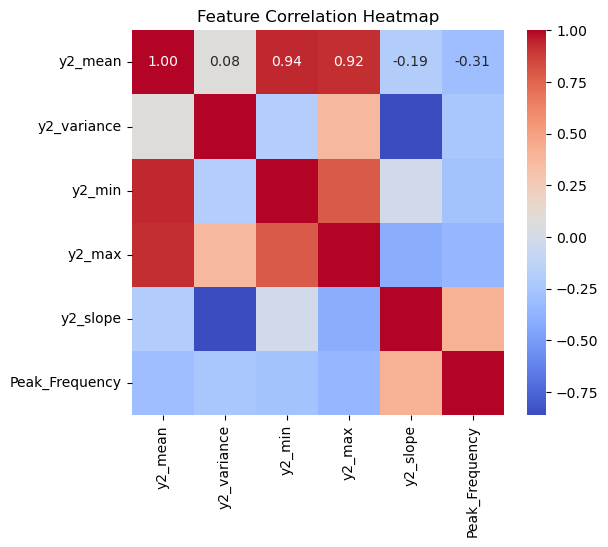

In [37]:
heatmap_plot(dataML)

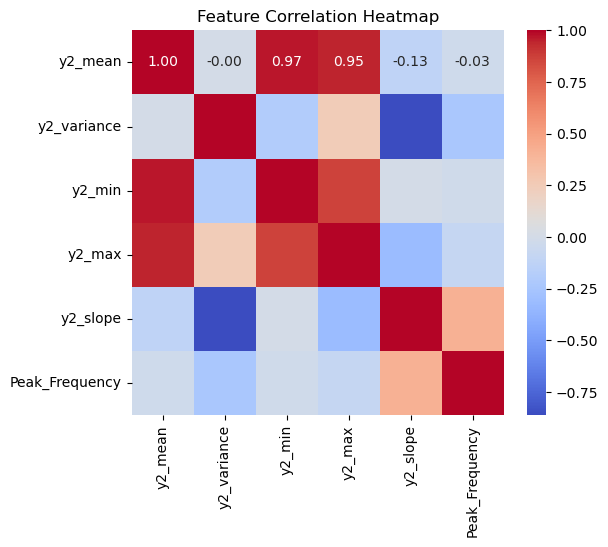

In [38]:
heatmap_plot(dataML_normal)

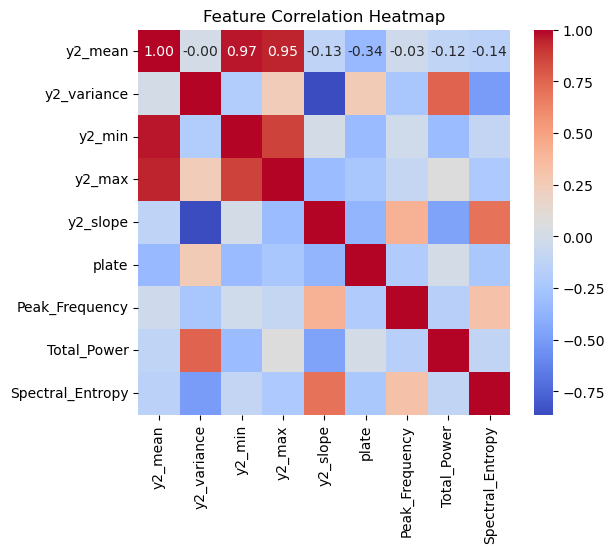

In [146]:
heatmap_plot(dataML_normal)

        PC1       PC2 Plate
0 -0.570902  0.136739     2
1 -3.100980 -1.416490     2
2 -2.453698  1.394224     2
3  0.115644 -0.851539     3
4 -1.891948 -0.138102     3


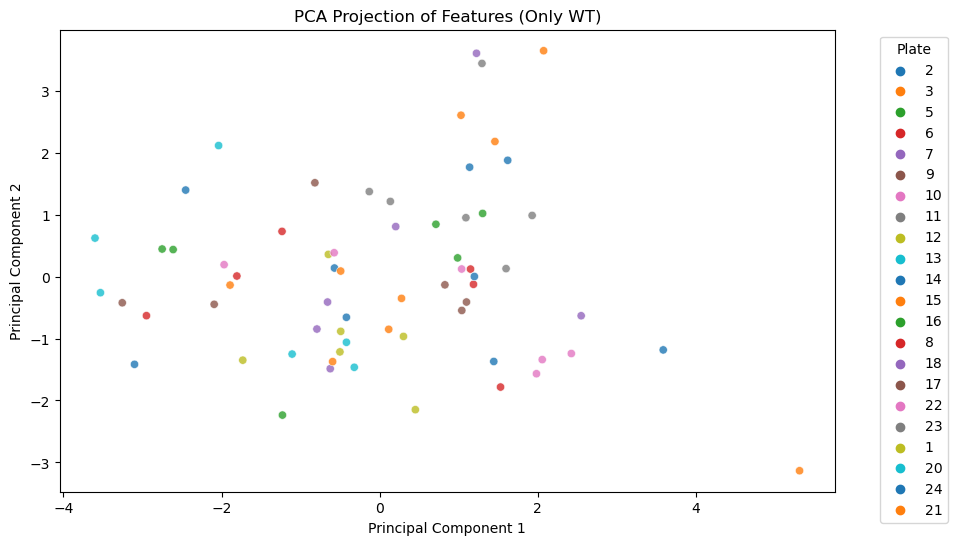

In [28]:
perform_pca_and_plot(dataML)

        PC1       PC2 Plate
0 -0.529651 -0.243690     2
1  0.942605 -2.801206     2
2  1.114634  0.401674     2
3 -0.792542 -0.851701     3
4  0.505365 -1.133533     3


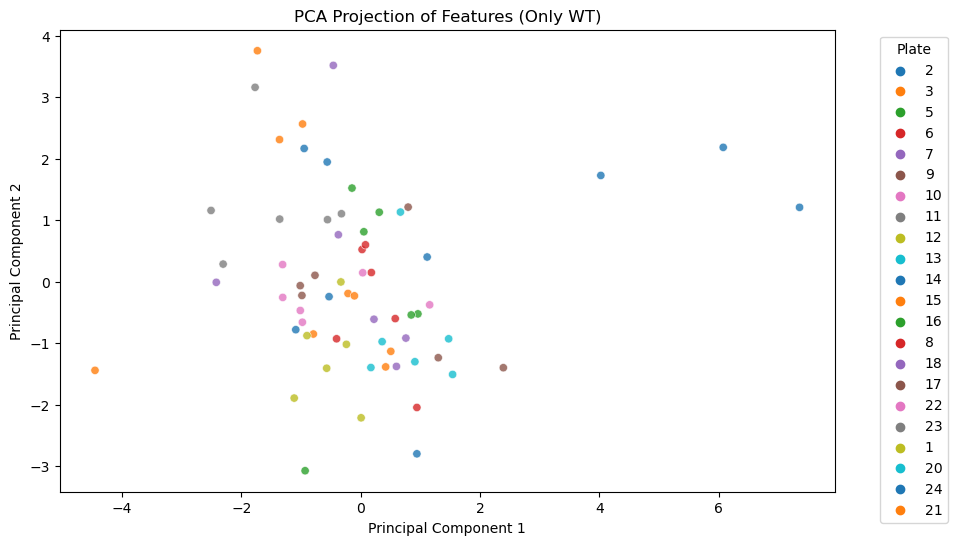

In [29]:
perform_pca_and_plot(dataML_normal)

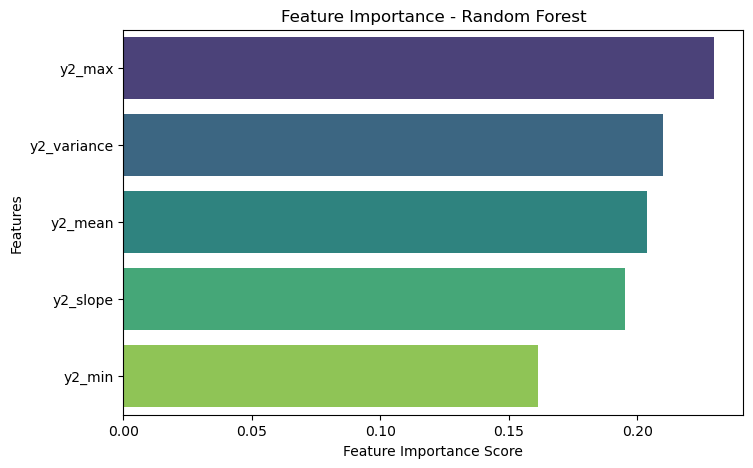

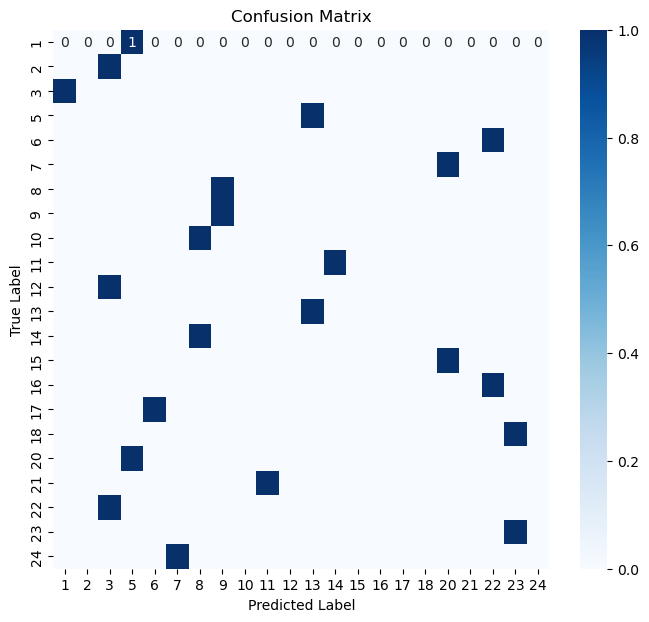

{'Accuracy': 0.13636363636363635, 'MCC': 0.0973689650919034}


In [34]:
result(dataML)

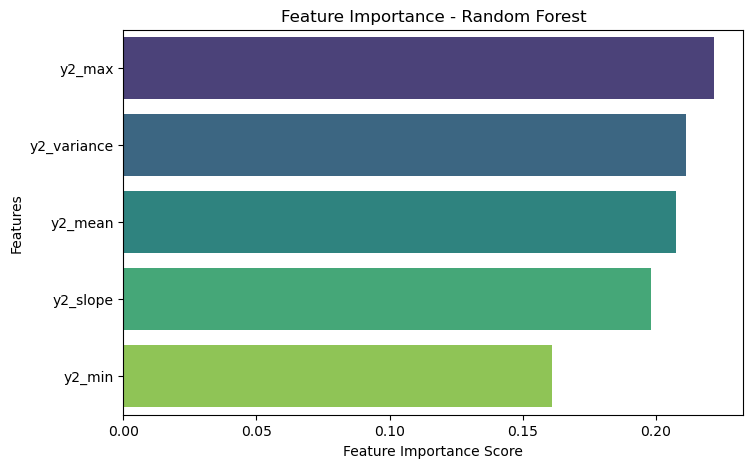

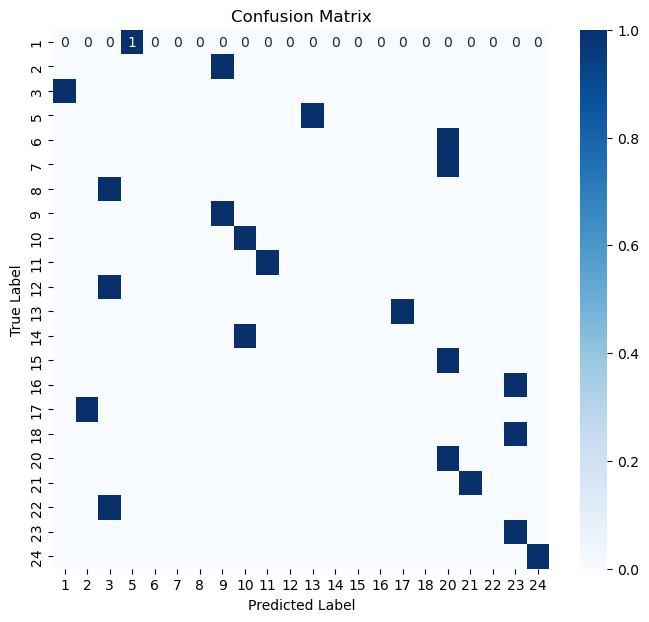

{'Accuracy': 0.3181818181818182, 'MCC': 0.29478683118376914}


In [35]:
result(dataML_normal)

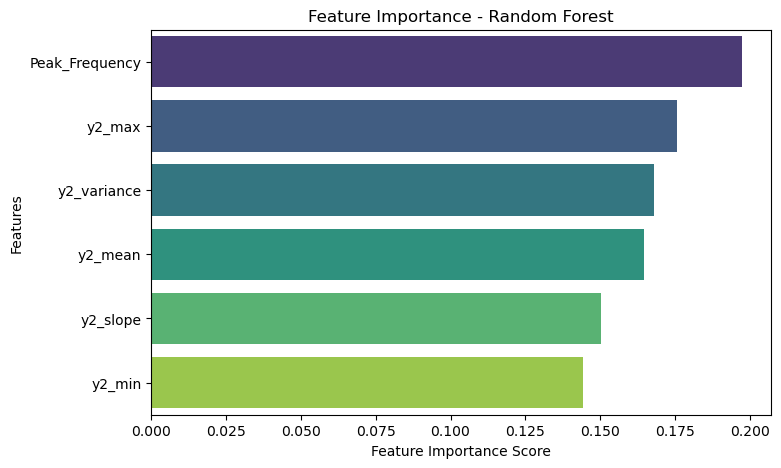

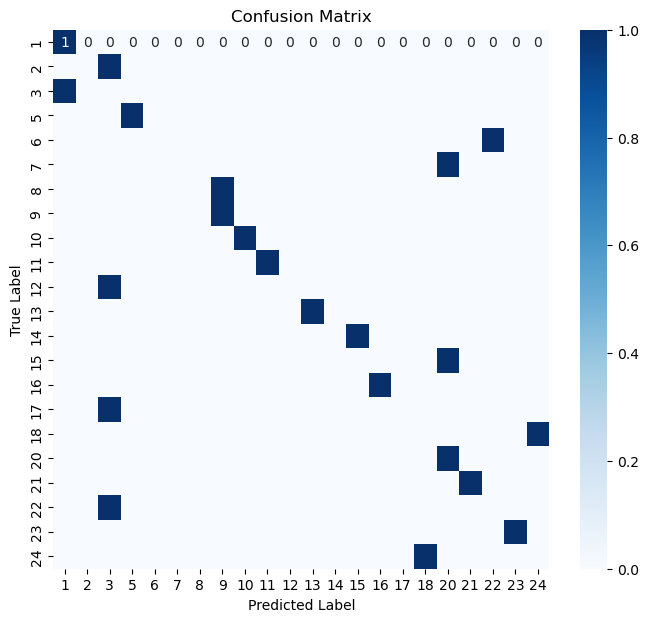

{'Accuracy': 0.45454545454545453, 'MCC': 0.43915503282683993}


In [147]:
result(dataML)

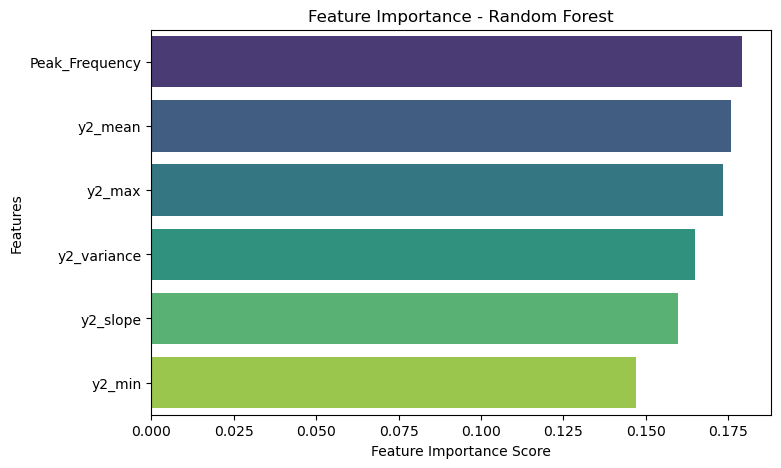

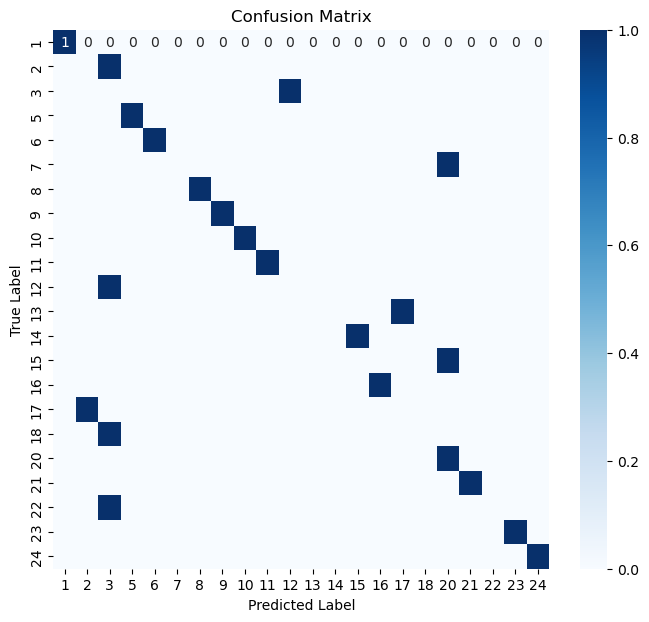

{'Accuracy': 0.5454545454545454, 'MCC': 0.5343217995738013}


In [148]:
result(dataML_normal)

In [37]:
# ML
classificaiton_WT(dataML,100)

Average MCC: 0.16720762725741103
Average Accuracy: 0.2009090909090909


In [18]:
classificaiton_WT(dataML_normal,100)

Average MCC: 0.21385260176571402
Average Accuracy: 0.24499999999999997


In [151]:
# add PSD
classificaiton_WT(dataML,100)

Average MCC: 0.33725308362145767
Average Accuracy: 0.36090909090909096


In [152]:
classificaiton_WT(dataML_normal,100)

Average MCC: 0.39155866725942806
Average Accuracy: 0.4127272727272727


## HL

In [9]:

dataHL=df[df['light_regime']=='20h_HL']
r2 = {
    1: 0.017538800932757396,
    2: -0.0556566278446737,
    3: -0.03579235773627947,
    4: -0.03904114131549795,
    5: -0.05963069396524156,
    6: -0.003682843501592073,
    7: 0.024161812033755007,
    8: 0.03631765787976693,
    9: 0.04196907101163208,
    10: 0.021928062605505205,
    11: -0.021570682928899192,
    12: -0.006649886776277614,
    13: -0.006969156328892485,
    14: 0.019139554106492252,
    15: 0.012464309492880077,
    16: -0.0068726823905841386,
    18: -0.018112092649827532,
    20: -0.020789424493370533,
    21: -0.020371006627794643,
    22: -0.021703721063566574,
    23: 0.013355994127583952,
    24: 0.12092610821413213,
    99: -0.005503952861565671
}

In [10]:
dataHL.shape

(9175, 380)

In [15]:
dataHL_normal= data_normalize(dataHL,'20h_HL',r2) 

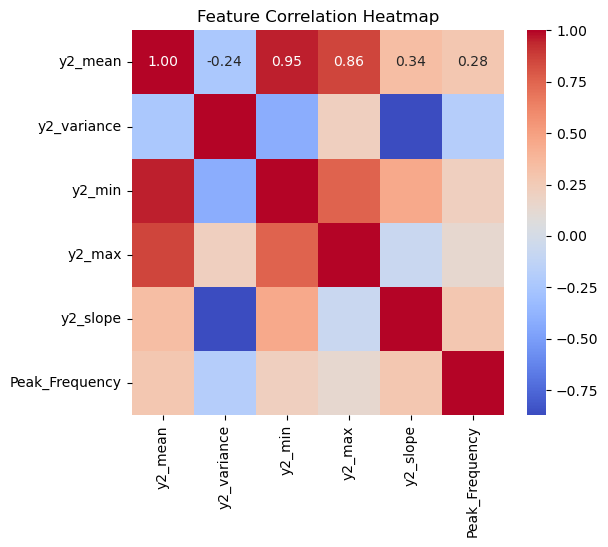

In [39]:
heatmap_plot(dataHL)

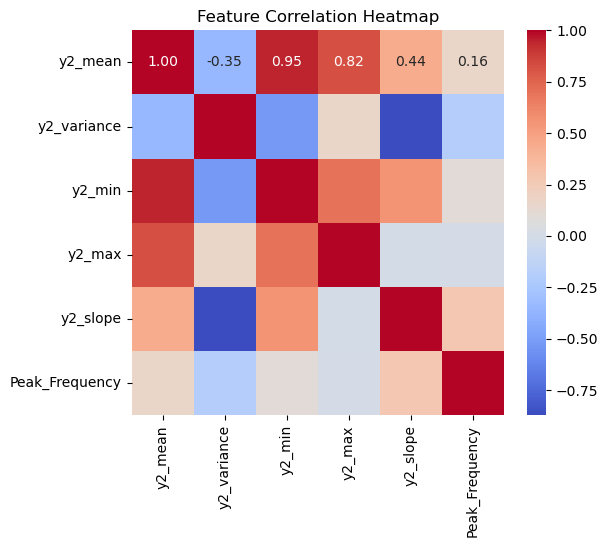

In [40]:
heatmap_plot(dataHL_normal)

        PC1       PC2 Plate
0 -2.215155 -0.085078     2
1 -1.972137 -0.564182     2
2 -1.243928 -1.247562     2
3 -1.666580 -0.988944     3
4 -1.449693 -0.541340     3


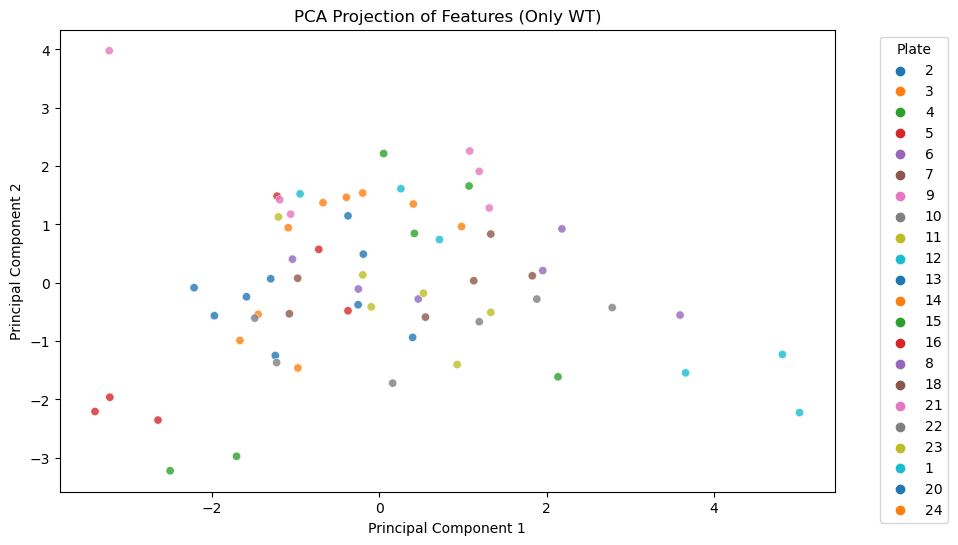

In [32]:
perform_pca_and_plot(dataHL)

        PC1       PC2 Plate
0  0.047312  1.305819     2
1 -0.243230  0.887111     2
2 -1.084538  0.312633     2
3  0.233086 -0.179202     3
4  0.025282  0.323407     3


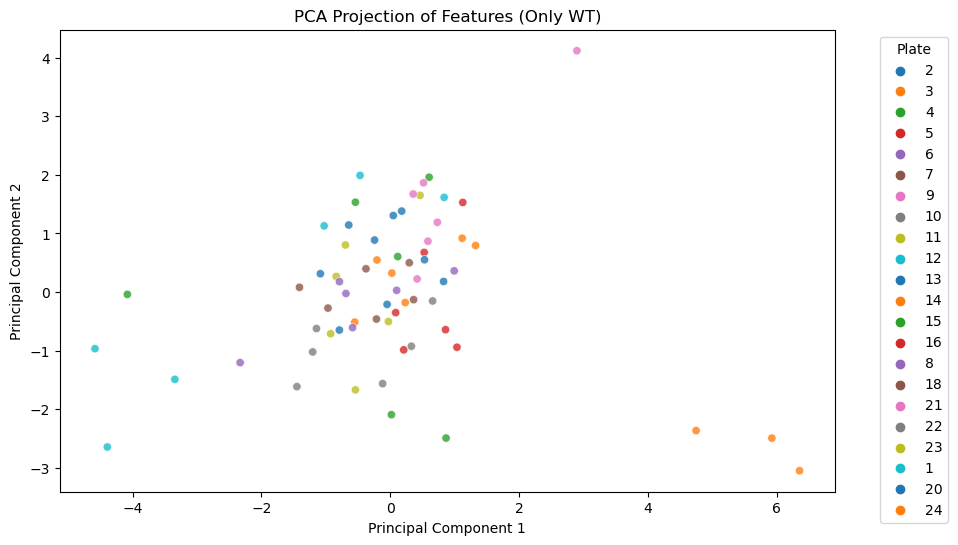

In [34]:
perform_pca_and_plot(dataHL_normal)

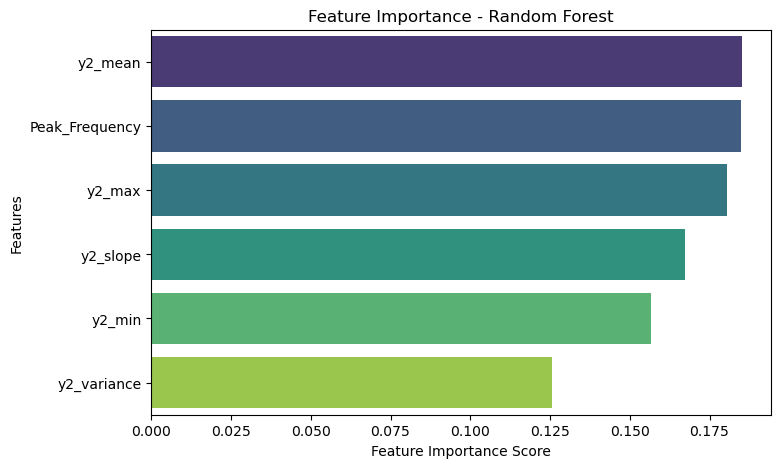

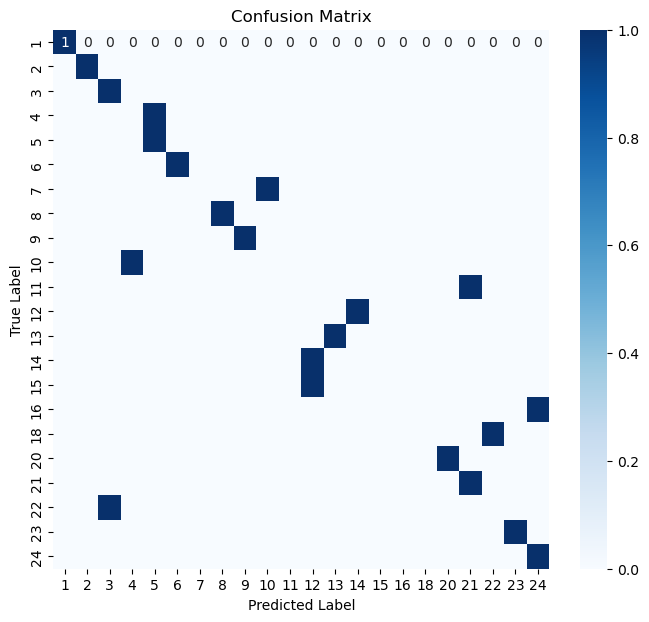

{'Accuracy': 0.5454545454545454, 'MCC': 0.5295721782260816}


In [35]:
result(dataHL)

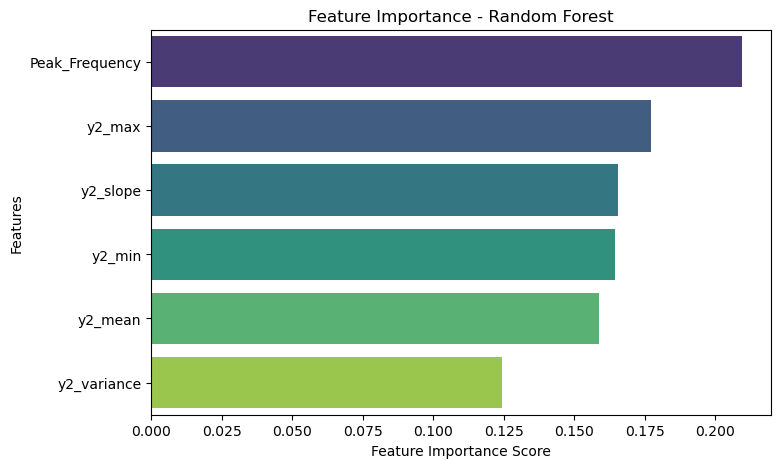

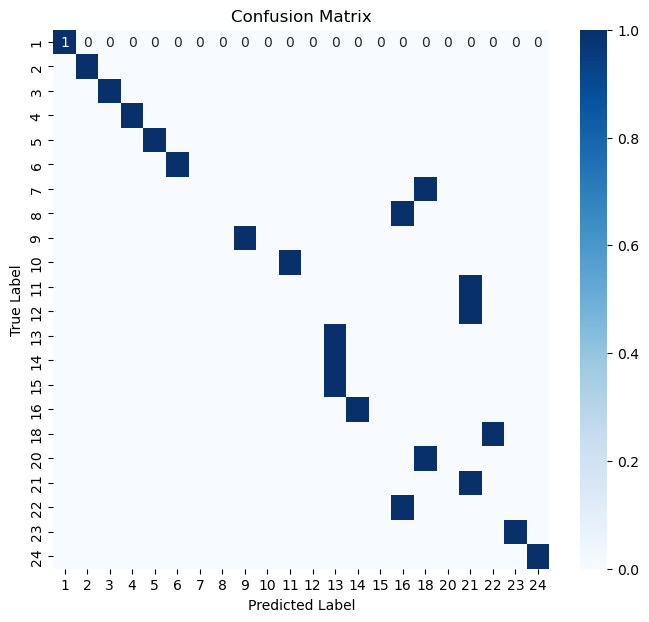

{'Accuracy': 0.5, 'MCC': 0.4846567477537935}


In [169]:
result(dataHL_normal)

In [18]:
classificaiton_WT(dataHL,100)

Average MCC: 0.5238788455613362
Average Accuracy: 0.5368181818181817


In [170]:
classificaiton_WT(dataHL_normal,100)

Average MCC: 0.4879593023285975
Average Accuracy: 0.5031818181818182


## 30S-30S

In [42]:
data30s=df[df['light_regime']=='30s-30s']

r3={1: 0.027089245441506423,
 2: -0.02294089126193909,
 3: -0.021198244253720765,
 4: -0.027052191116055217,
 5: -0.0341945302895822,
 6: -0.012415330469563819,
 7: -0.030711803988415765,
 8: -0.006825665531140801,
 9: 0.014452758548868513,
 10: 0.017174250221259915,
 11: -0.03356007806515098,
 12: -0.019968652221982006,
 13: -0.010484501365216664,
 14: -0.01866353552073209,
 15: -0.004230836446482455,
 16: 0.016867335685513137,
 17: 0.022341258671195758,
 18: 0.007539570141179644,
 20: 0.012620403005601646,
 21: -0.01809947947232384,
 22: -0.022790179626579313,
 23: -0.02315146368301626,
 24: 0.1407506311052283,
 99: 0.04745193015528404}

In [43]:
data30s_normal= data_normalize(data30s,'30s-30s',r3) 

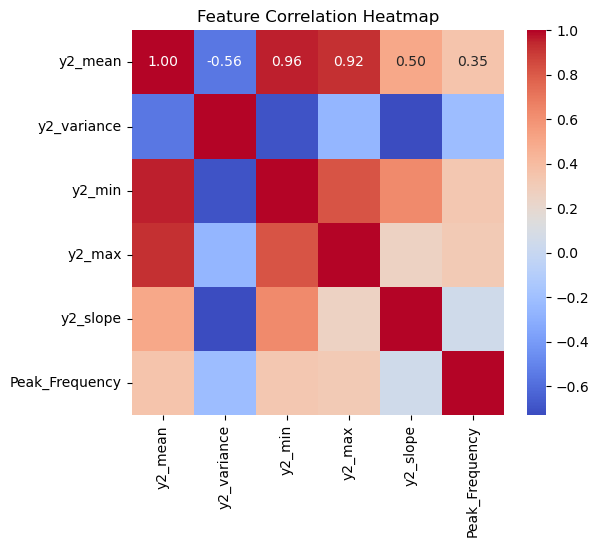

In [44]:
heatmap_plot(data30s)

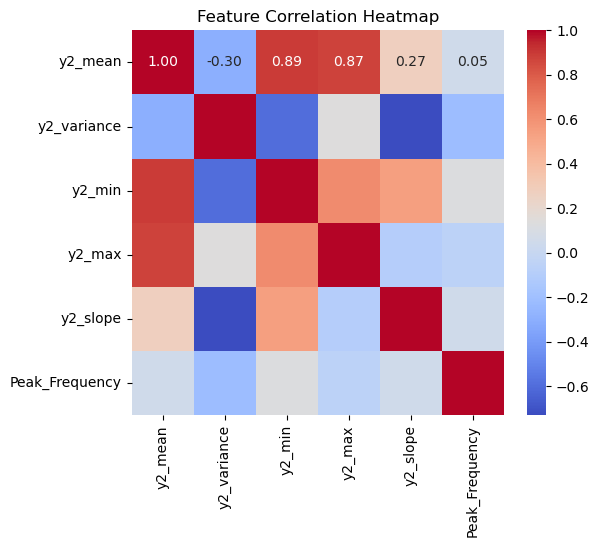

In [45]:
heatmap_plot(data30s_normal)

        PC1       PC2 Plate
0 -1.908515  0.150766     3
1 -2.413383 -0.180759     3
2 -2.199362  0.143391     3
3 -3.689397 -1.676722     5
4 -3.301019 -1.390851     5


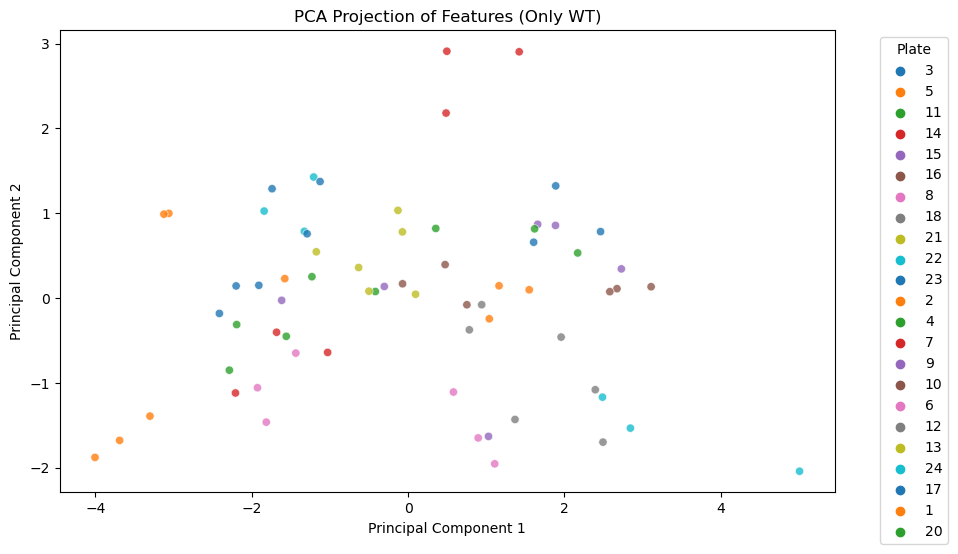

In [46]:
perform_pca_and_plot(data30s)

        PC1       PC2 Plate
0  1.154008 -0.732397     3
1  1.774957 -1.007299     3
2  1.494630 -0.613540     3
3  2.648298 -2.450406     5
4  2.275287 -2.303982     5


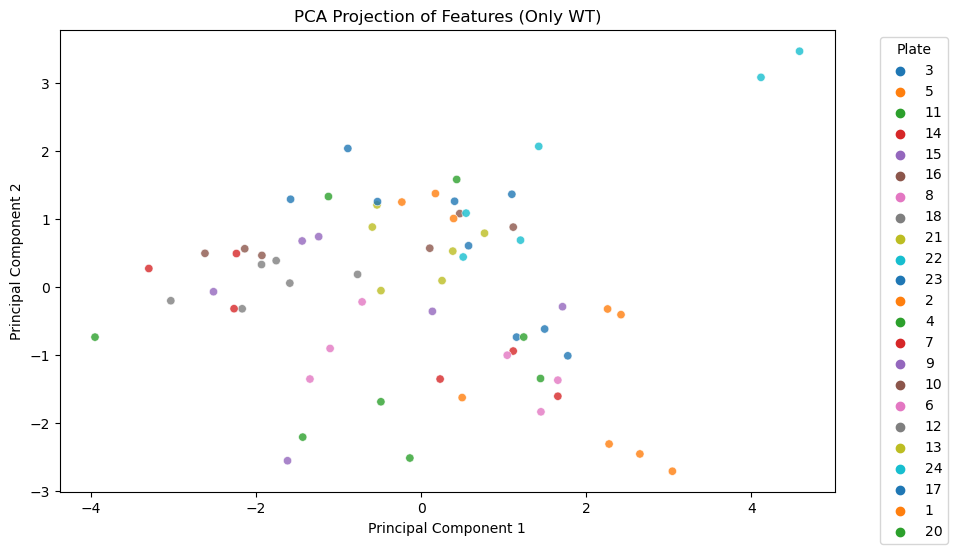

In [47]:
perform_pca_and_plot(data30s_normal)

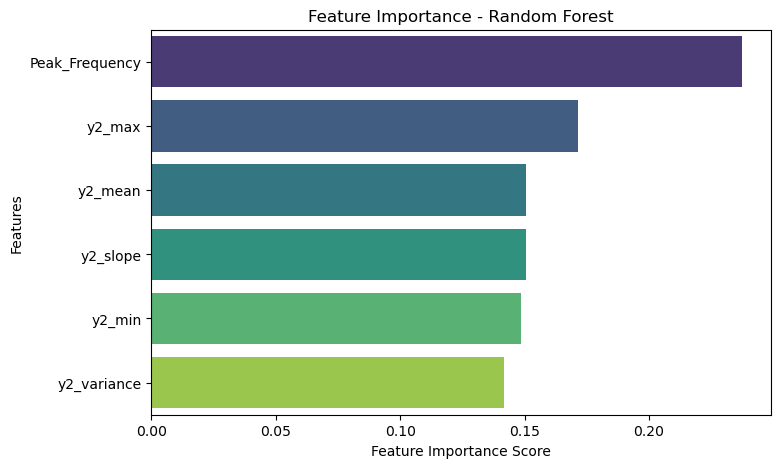

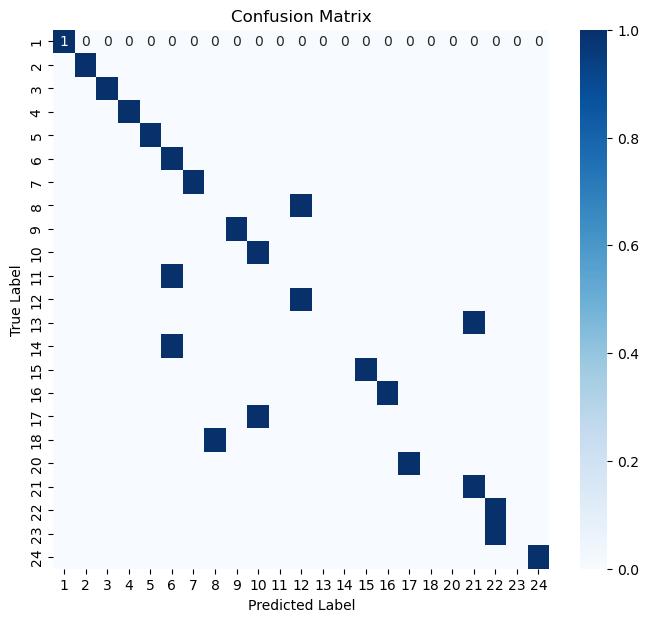

{'Accuracy': 0.6521739130434783, 'MCC': 0.6453540827264117}


In [48]:
result(data30s)

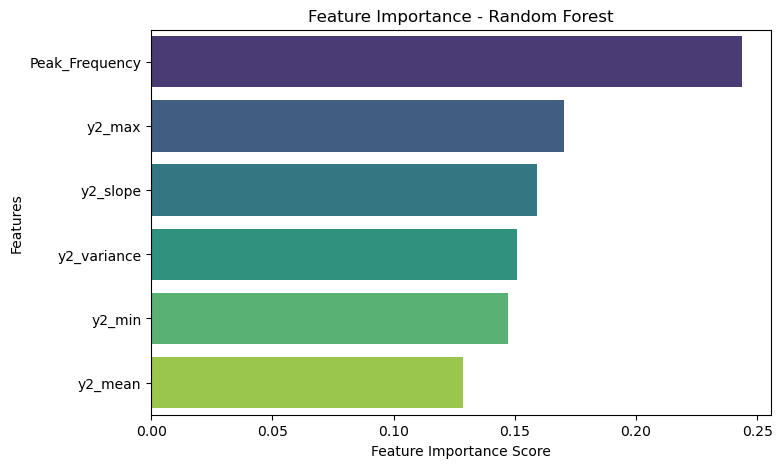

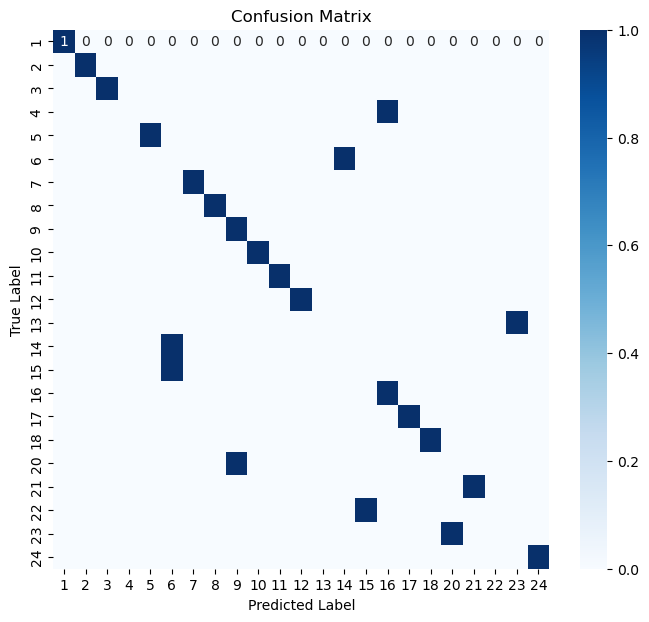

{'Accuracy': 0.6521739130434783, 'MCC': 0.640170431852473}


In [49]:
result(data30s_normal)

In [50]:
classificaiton_WT(data30s,100)

Average MCC: 0.6859693325821088
Average Accuracy: 0.6917391304347825


In [51]:
classificaiton_WT(data30s_normal,100)

Average MCC: 0.675527035508856
Average Accuracy: 0.6817391304347826
